<a href="https://colab.research.google.com/github/aiaaee/Obesity_Prediction/blob/main/Obesity_Prediction_With_Neuralnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from zipfile import ZipFile
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder , StandardScaler
from torch.utils.data import DataLoader , TensorDataset

In [ ]:
with ZipFile('/content/Obesity_prediction.zip' , 'r') as zipfile :
  zipfile.extractall('./')

In [ ]:
data = pd.read_csv('/content/ObesityDataSet_raw_and_data_sinthetic.csv')

In [ ]:
data.head(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
# data.isnull().sum()

In [ ]:
X = data.drop('NObeyesdad' , axis=1)
y = data['NObeyesdad']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   int64  
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [ ]:
cat_col = []
for col in X.columns :
  if X[col].dtype == 'object':
    cat_col.append(col)

In [ ]:
cat_col

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']

In [ ]:
X = pd.get_dummies(X , prefix=cat_col , dtype=float)

In [ ]:
y.value_counts()

,count
NObeyesdad,
Obesity_Type_I,351
Obesity_Type_III,324
Obesity_Type_II,297
Overweight_Level_I,290
Overweight_Level_II,290
Normal_Weight,287
Insufficient_Weight,272


In [ ]:
y_scaled = [0 if i == 'Insufficient_Weight' else 1 if i == 'Normal_Weight' else 2 if i == 'Overweight_Level_II' else 3 if i == 'Overweight_Level_I' else 4 if i == 'Obesity_Type_II' else 5 if i == 'Obesity_Type_III' else 6  for i in y ]

In [ ]:
X = torch.tensor(X.values , dtype=torch.float)

In [ ]:
y = torch.tensor(y_scaled , dtype=torch.long)

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 )

In [ ]:
X_train.shape  , y_train.shape

(torch.Size([1688, 31]), torch.Size([1688]))

In [ ]:
train_dataset = TensorDataset(X_train , y_train)
test_dataset = TensorDataset(X_test , y_test)

In [ ]:
train_loader = DataLoader(train_dataset , batch_size=32 , shuffle=True)
test_loader = DataLoader(test_dataset , batch_size = len(test_dataset.tensors[0]) , shuffle=False )

In [ ]:
for i , j in train_loader :
  print(i.shape)
  print(j.shape)
  break

torch.Size([32, 31])
torch.Size([32])


In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self , in_dim , out_dim):
    super().__init__()
    self.flat = nn.Flatten()
    self.L1 = nn.Linear(in_dim , 32)
    self.bn1 = nn.BatchNorm1d(32)
    self.L2 = nn.Linear(32 , 64)
    self.bn2 = nn.BatchNorm1d(64)
    self.dropout = nn.Dropout1d(0.4)
    self.L3 = nn.Linear(64 , out_dim)

  def forward(self , x ):
    x = self.flat(x)
    x = F.relu(self.L1(x))
    x = self.bn1(x)
    x = F.relu(self.L2(x))
    x = self.bn2(x)
    x = self.dropout(x)
    return self.L3(x)

In [ ]:
x = torch.randn(32 , 31)

model  = NeuralNetwork(31 ,7)

model(x).size()

torch.Size([32, 7])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters() , lr=0.0001)

In [ ]:
epochs = 10
train_loss_history = []
test_loss_history = []

for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    correct_train = 0
    total_train = 0

    model.train()
    for i, j in train_loader:
        prediction = model(i)
        loss = criterion(prediction, j)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        predicted = torch.argmax(prediction, dim=1)
        correct_train += (predicted == j).sum().item()
        total_train += j.size(0)

    train_accuracy = correct_train / total_train

    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for test_i, test_j in test_loader:
            output = model(test_i)
            t_loss = criterion(output, test_j)
            test_loss += t_loss.item()

            predicted = torch.argmax(output, dim=1)
            correct_test += (predicted == test_j).sum().item()
            total_test += test_j.size(0)

    test_accuracy = correct_test / total_test

    train_loss_history.append(train_loss / len(train_loader))
    test_loss_history.append(test_loss / len(test_loader))

    print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss / len(train_loader):.4f} | "
          f"Test Loss: {test_loss / len(test_loader):.4f} | "
          f"Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10 | Train Loss: 1.8151 | Test Loss: 1.6633 | Train Accuracy: 0.2553 | Test Accuracy: 0.4043
Epoch 2/10 | Train Loss: 1.6765 | Test Loss: 1.5110 | Train Accuracy: 0.3264 | Test Accuracy: 0.4965
Epoch 3/10 | Train Loss: 1.5580 | Test Loss: 1.4381 | Train Accuracy: 0.3750 | Test Accuracy: 0.5508
Epoch 4/10 | Train Loss: 1.5378 | Test Loss: 1.3759 | Train Accuracy: 0.3649 | Test Accuracy: 0.5745
Epoch 5/10 | Train Loss: 1.4828 | Test Loss: 1.3245 | Train Accuracy: 0.4028 | Test Accuracy: 0.6170
Epoch 6/10 | Train Loss: 1.4468 | Test Loss: 1.3004 | Train Accuracy: 0.4224 | Test Accuracy: 0.5887
Epoch 7/10 | Train Loss: 1.4350 | Test Loss: 1.2723 | Train Accuracy: 0.4254 | Test Accuracy: 0.6312
Epoch 8/10 | Train Loss: 1.4064 | Test Loss: 1.2389 | Train Accuracy: 0.4319 | Test Accuracy: 0.6501
Epoch 9/10 | Train Loss: 1.3906 | Test Loss: 1.1937 | Train Accuracy: 0.4414 | Test Accuracy: 0.6643
Epoch 10/10 | Train Loss: 1.3597 | Test Loss: 1.1832 | Train Accuracy: 0.4627 | Test Accura

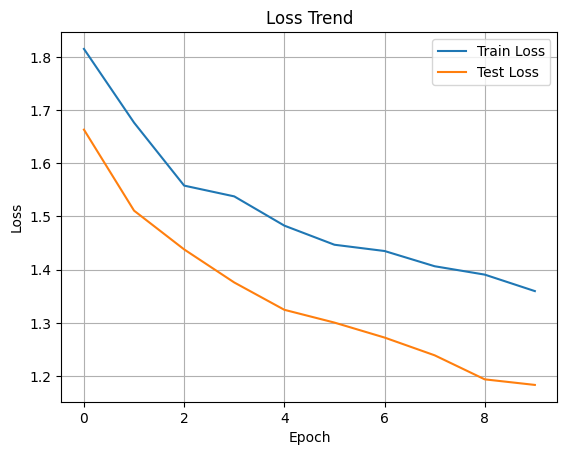

In [ ]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Trend")
plt.grid(True)
plt.show()